In [ ]:
import sys
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from pprint import pprint
from datetime import datetime, timedelta


In [183]:
def prepare_kijkcijfers():
    start_date = datetime(2016, 1, 1)
    end_date = datetime.today()

    all_records = []

    current_date = start_date
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        
        url = f"https://api.cim.be/api/cim_tv_public_results_daily_views?dateDiff={date_str}&reportType=north"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            
            data = response.json()
            records = data.get('hydra:member', [])
            
            all_records.extend(records)
        
        except Exception as e:
            print(f"Failed for date {date_str}: {e}")
        
        current_date += timedelta(days=1)

    df = pd.DataFrame(all_records)

    df['dateResult'] = pd.to_datetime(df['dateResult'])
    df['weekday'] = df['dateResult'].dt.weekday
    df['day'] = df['dateResult'].dt.day
    df['month'] = df['dateResult'].dt.month
    df['year'] = df['dateResult'].dt.year

    df['startTime'] = pd.to_datetime(df['startTime'], format='%H:%M:%S', errors='coerce')
    df['start_hour'] = df['startTime'].dt.hour
    df['start_minute'] = df['startTime'].dt.minute

    df['rLength'] = pd.to_timedelta(df['rLength'], errors='coerce')
    df['duration_seconds'] = df['rLength'].dt.total_seconds()

    df = df.drop(columns=['@id', '@type', 'reportType', 'id', 'dateImport', 'category', 'ratePerc', 'shr','rateInKAll', 'dateDiff', 'dateResult', 'startTime', 'rLength'])

    df.dropna(inplace=True)


    return df

kijkcijfers = prepare_kijkcijfers()
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63368 entries, 0 to 63498
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           63368 non-null  object 
 1   description       63368 non-null  object 
 2   channel           63368 non-null  object 
 3   rateInK           63368 non-null  object 
 4   live              63368 non-null  int64  
 5   weekday           63368 non-null  int32  
 6   day               63368 non-null  int32  
 7   month             63368 non-null  int32  
 8   year              63368 non-null  int32  
 9   start_hour        63368 non-null  float64
 10  start_minute      63368 non-null  float64
 11  duration_seconds  63368 non-null  float64
dtypes: float64(3), int32(4), int64(1), object(4)
memory usage: 5.3+ MB


In [184]:
kijkcijfers2 = kijkcijfers

In [185]:
kijkcijfers['rateInK'] = pd.to_numeric(
    kijkcijfers['rateInK']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False),
    errors='coerce'  # Invalid values become NaN
)

In [186]:
kijkcijfers['channel'] = kijkcijfers['channel'].astype("string")
kijkcijfers['description'] = kijkcijfers['description'].astype("string")

In [213]:
kijkcijfers['ranking'] = kijkcijfers['ranking'].astype(int)

In [214]:
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50694 entries, 51573 to 56542
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           50694 non-null  int32  
 1   description       50694 non-null  string 
 2   channel           50694 non-null  string 
 3   rateInK           50694 non-null  float64
 4   live              50694 non-null  int64  
 5   weekday           50694 non-null  int32  
 6   day               50694 non-null  int32  
 7   month             50694 non-null  int32  
 8   year              50694 non-null  int32  
 9   start_hour        50694 non-null  float64
 10  start_minute      50694 non-null  float64
 11  duration_seconds  50694 non-null  float64
dtypes: float64(4), int32(5), int64(1), string(2)
memory usage: 4.1 MB


In [215]:
kijkcijfers = kijkcijfers[kijkcijfers['rateInK'].notna()]
kijkcijfers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50694 entries, 51573 to 56542
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ranking           50694 non-null  int32  
 1   description       50694 non-null  string 
 2   channel           50694 non-null  string 
 3   rateInK           50694 non-null  float64
 4   live              50694 non-null  int64  
 5   weekday           50694 non-null  int32  
 6   day               50694 non-null  int32  
 7   month             50694 non-null  int32  
 8   year              50694 non-null  int32  
 9   start_hour        50694 non-null  float64
 10  start_minute      50694 non-null  float64
 11  duration_seconds  50694 non-null  float64
dtypes: float64(4), int32(5), int64(1), string(2)
memory usage: 4.1 MB


In [216]:
kijkcijfers.head(30)

,ranking,description,channel,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
51573,15,DE RECHTBANK,PLAY4,181392.0,7,5,7,10,2023,20.0,5.0,2218.0
51708,10,EXPEDITIE PAIRI DAIZA,VTM,298837.0,7,5,14,10,2023,19.0,55.0,1558.0
33909,1,THUIS,EEN,1235435.0,0,2,26,5,2021,20.0,11.0,1430.0
3543,19,DE KLEEDKAMER,CANVAS,212494.0,0,0,27,3,2017,21.0,18.0,2879.0
1864,2,HET 7 UUR-JOURNAAL,EEN,1229894.0,0,1,3,1,2017,19.0,0.0,2497.0
33531,3,THE VOICE VAN VLAANDEREN - LIVE,VTM,797669.0,0,4,7,5,2021,20.0,43.0,7546.0
48582,4,IEDEREEN BEROEMD,VRT 1,706274.0,0,3,11,5,2023,19.0,51.0,1686.0
54055,17,NIEUWS 13U VTM,VTM,238173.0,7,3,8,2,2024,12.0,59.0,1598.0
39499,11,DE AFSPRAAK,Canvas,383199.0,0,1,1,3,2022,20.0,41.0,3074.0
15135,9,HET JOURNAAL LAAT,EEN,394074.0,0,6,28,10,2018,22.0,23.0,1202.0


In [217]:
kijkcijfers.describe()

,ranking,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
count,50694.000000,5.069400e+04,50694.000000,50694.000000,50694.000000,50694.000000,50694.000000,50694.000000,50694.000000,50694.000000
mean,10.575749,4.447540e+05,3.468892,3.005681,15.699826,6.464000,2020.585671,18.621040,27.969306,2683.461100
std,5.845529,2.778352e+05,8.223778,2.001648,8.786099,3.498778,2.514854,2.888941,19.908558,1763.132488
min,1.000000,1.588700e+04,0.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,0.000000,900.000000
25%,6.000000,2.290682e+05,0.000000,1.000000,8.000000,3.000000,2018.000000,18.000000,10.000000,1567.000000
50%,11.000000,3.582695e+05,0.000000,3.000000,16.000000,6.000000,2021.000000,19.000000,29.500000,2355.000000
75%,16.000000,6.045470e+05,0.000000,5.000000,23.000000,10.000000,2023.000000,20.000000,44.000000,3062.000000
max,38.000000,2.494114e+06,28.000000,6.000000,31.000000,12.000000,2025.000000,23.000000,59.000000,35359.000000


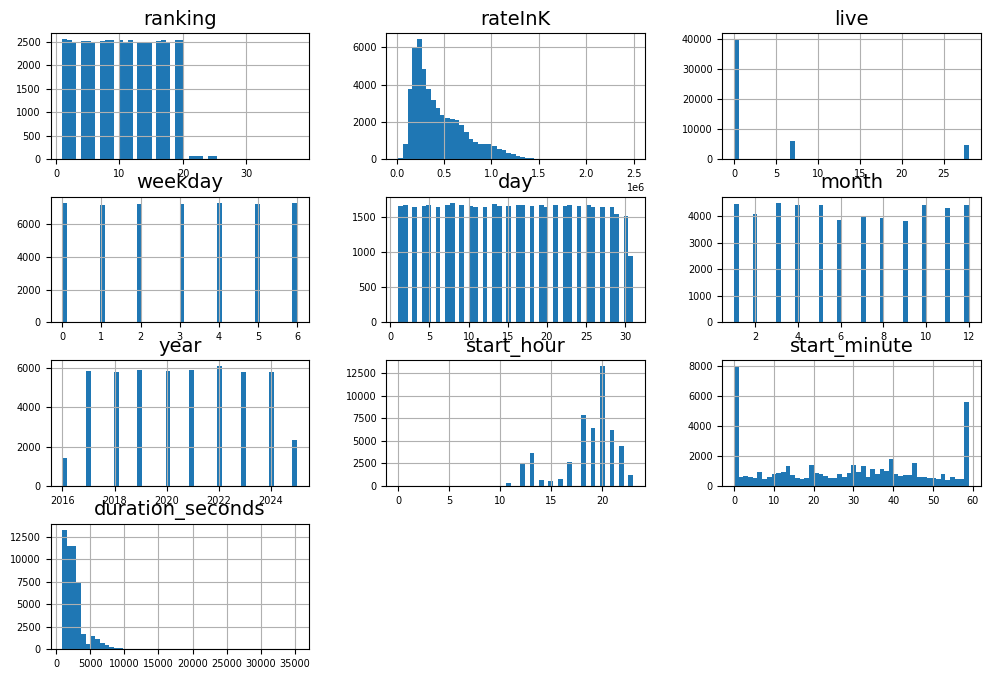

In [219]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)

kijkcijfers.hist(bins=50, figsize=(12, 8))
plt.show()

In [220]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(kijkcijfers, test_size=0.2, random_state=42)

In [221]:
len(train_set)

40555

In [222]:
len(test_set)

10139

In [223]:
train_set.head()

,ranking,description,channel,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
20310,4,WIELRENNEN. RONDE VAN FRANKRIJK - RIT 9 SAINT-...,EEN,632101.0,0,6,14,7,2019,14.0,1.0,14400.0
32977,9,HET 1 UUR-JOURNAAL,EEN,426927.0,0,4,9,4,2021,13.0,0.0,2127.0
4898,10,WIELRENNEN. DAUPHINE LIBERE,EEN,295944.0,0,6,4,6,2017,13.0,40.0,5781.0
16895,9,GROETEN UIT...,VTM,634495.0,0,3,24,1,2019,20.0,38.0,2990.0
38193,5,WIELERJAAR 2021,EEN,726873.0,0,6,26,12,2021,19.0,30.0,1963.0


In [224]:
kijkcijfers = train_set.copy()

In [225]:
corr_matrix = kijkcijfers.corr(numeric_only=True)

In [274]:
corr_matrix["rateInK"].sort_values(ascending=False)

rateInK             1.000000
start_hour          0.120925
day                -0.020963
live               -0.039004
month              -0.041662
year               -0.074702
duration_seconds   -0.093045
start_minute       -0.097344
weekday            -0.126010
ranking            -0.859207
Name: rateInK, dtype: float64

In [275]:
corr_matrix

,ranking,rateInK,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
ranking,1.000000,-0.859207,-0.005409,-0.002209,0.003434,-0.000981,0.005854,-0.071674,0.073917,0.073907
rateInK,-0.859207,1.000000,-0.039004,-0.126010,-0.020963,-0.041662,-0.074702,0.120925,-0.097344,-0.093045
live,-0.005409,-0.039004,1.000000,-0.001054,-0.000861,0.026035,0.606881,0.004616,0.008283,0.010083
weekday,-0.002209,-0.126010,-0.001054,1.000000,0.001315,0.002955,0.002350,-0.126151,-0.003009,0.164096
day,0.003434,-0.020963,-0.000861,0.001315,1.000000,0.004350,-0.005566,0.006454,-0.003514,0.005738
month,-0.000981,-0.041662,0.026035,0.002955,0.004350,1.000000,-0.145210,-0.014736,0.002374,0.013158
year,0.005854,-0.074702,0.606881,0.002350,-0.005566,-0.145210,1.000000,-0.021539,-0.001758,0.003713
start_hour,-0.071674,0.120925,0.004616,-0.126151,0.006454,-0.014736,-0.021539,1.000000,-0.072953,-0.036937
start_minute,0.073917,-0.097344,0.008283,-0.003009,-0.003514,0.002374,-0.001758,-0.072953,1.000000,0.049926
duration_seconds,0.073907,-0.093045,0.010083,0.164096,0.005738,0.013158,0.003713,-0.036937,0.049926,1.000000


In [276]:
kijkcijfers = train_set.drop("rateInK", axis=1)
kijkcijfers_labels = train_set["rateInK"].copy()

In [277]:
channel_cat = kijkcijfers[["channel"]]
channel_cat.head(10)

,channel
20310,EEN
32977,EEN
4898,EEN
16895,VTM
38193,EEN
48478,Canvas
1536,VTM
26376,VIER
56854,VRT CANVAS
20234,EEN


In [278]:
description_cat = kijkcijfers[["description"]]
description_cat.head(10)

,description
20310,WIELRENNEN. RONDE VAN FRANKRIJK - RIT 9 SAINT-...
32977,HET 1 UUR-JOURNAAL
4898,WIELRENNEN. DAUPHINE LIBERE
16895,GROETEN UIT...
38193,WIELERJAAR 2021
48478,TER ZAKE
1536,STADION
26376,GERT LATE NIGHT - LOCKDOWN
56854,DE AFSPRAAK
20234,WIELRENNEN. RONDE VAN FRANKRIJK - RIT 5 SAINT-...


In [279]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
channel_cat_encoded = ordinal_encoder.fit_transform(channel_cat)
channel_cat_encoded[:10]

array([[ 4.],
       [ 4.],
       [ 4.],
       [24.],
       [ 4.],
       [ 2.],
       [24.],
       [18.],
       [23.],
       [ 4.]])

In [280]:
ordinal_encoder.categories_

[array(['CANVAS', 'CAZ', 'Canvas', 'DAZN PRO LEAGUE 1 (NL)', 'EEN',
        'EEN,VTM,PLAY4', 'ELEVEN PRO LEAGUE 1 NL', 'EUROSPORT 1 (NL)',
        'KETNET', 'LA UNE', 'OP 12', 'PLAY SPORTS OPEN', 'PLAY4', 'PLAY5',
        'PLAY6', 'Q2', 'RTL-TVI', 'TF1', 'VIER', 'VIJF', 'VITAYA', 'VRT 1',
        'VRT 1/VTM/Play4', 'VRT CANVAS', 'VTM', 'VTM GOLD', 'VTM2', 'VTM3',
        'VTM4', 'ZES'], dtype=object)]

In [281]:
description_cat_cat_encoded = ordinal_encoder.fit_transform(description_cat)
description_cat_cat_encoded[:10]

array([[4470.],
       [1406.],
       [4251.],
       [1339.],
       [4178.],
       [2814.],
       [2714.],
       [1273.],
       [ 738.],
       [4454.]])

In [282]:
ordinal_encoder.categories_

[array(['#HETISINGEWIKKELD', '#LIKEME', '#LIKEME IN CONCERT 3', ...,
        'ZWARE JONGENS', 'ZWEMMEN. ANTWERPEN', 'ZWEMMEN. EK.MUNCHEN (S.)'],
       dtype=object)]

In [283]:
from sklearn.preprocessing import OneHotEncoder

# Select the categorical columns
categorical_cols = kijkcijfers[['channel', 'description']]

# Optionally ensure string dtype (for consistency)
#categorical_cols = categorical_cols.astype("string")

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False to get array output

# Fit and transform
encoded_array = encoder.fit_transform(categorical_cols)

# Get the feature names (column names)
encoded_kijkcijfers = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols.columns))

# Optional: Reset index to align with original kijkcijfers (if needed)
encoded_kijkcijfers.index = kijkcijfers.index

# Concatenate with original kijkcijfers (optional)
kijkcijfers_encoded = pd.concat([kijkcijfers, encoded_kijkcijfers], axis=1)

# Drop original categorical columns if you don't need them
kijkcijfers_encoded = kijkcijfers_encoded.drop(columns=['channel', 'description'])

# Display result
print(kijkcijfers_encoded.head())

       ranking  live  weekday  day  month  year  start_hour  start_minute  \
20310        4     0        6   14      7  2019        14.0           1.0   
32977        9     0        4    9      4  2021        13.0           0.0   
4898        10     0        6    4      6  2017        13.0          40.0   
16895        9     0        3   24      1  2019        20.0          38.0   
38193        5     0        6   26     12  2021        19.0          30.0   

       duration_seconds  channel_CANVAS  ...  description_ZONDER STERREN  \
20310           14400.0             0.0  ...                         0.0   
32977            2127.0             0.0  ...                         0.0   
4898             5781.0             0.0  ...                         0.0   
16895            2990.0             0.0  ...                         0.0   
38193            1963.0             0.0  ...                         0.0   

       description_ZOO AUSTRALIE  description_ZOOKEEPER  \
20310                

In [284]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
numeric_cols = ['live', 'ranking', 'weekday', 'day', 'month', 'year', 'start_hour', 'start_minute', 'duration_seconds']  # adjust based on your kijkcijfers

scaler = StandardScaler()
scaled_data = scaler.fit_transform(kijkcijfers[numeric_cols])

# Replace or merge into kijkcijfers
kijkcijfers_scaled = kijkcijfers.copy()
kijkcijfers_scaled[numeric_cols] = scaled_data


In [285]:
kijkcijfers_scaled

,ranking,description,channel,live,weekday,day,month,year,start_hour,start_minute,duration_seconds
20310,-1.127354,WIELRENNEN. RONDE VAN FRANKRIJK - RIT 9 SAINT-...,EEN,-0.421892,1.495349,-0.192918,0.151534,-0.628885,-1.599706,-1.355486,6.567674
32977,-0.271812,HET 1 UUR-JOURNAAL,EEN,-0.421892,0.496298,-0.761317,-0.706490,0.166488,-1.945906,-1.405756,-0.315761
4898,-0.100703,WIELRENNEN. DAUPHINE LIBERE,EEN,-0.421892,1.495349,-1.329716,-0.134474,-1.424258,-1.945906,0.605034,1.733621
16895,-0.271812,GROETEN UIT...,VTM,-0.421892,-0.003227,0.943880,-1.564515,-0.628885,0.477492,0.504495,0.168261
38193,-0.956245,WIELERJAAR 2021,EEN,-0.421892,1.495349,1.171240,1.581574,0.166488,0.131292,0.102337,-0.407742
...,...,...,...,...,...,...,...,...,...,...,...
34914,-0.785137,VIVE LE VELO,EEN,-0.421892,-0.003227,-0.079238,0.151534,0.166488,0.823692,0.102337,0.763334
35171,-1.298462,STUDIO TOKIO,EEN,-0.421892,-0.502753,1.398599,0.151534,0.166488,0.131292,-0.048472,-0.529449
55453,0.754839,DE TAFEL VAN GERT,PLAY4,0.427026,-0.003227,0.261801,-0.706490,1.359548,0.477492,-1.405756,0.801472
40864,0.925948,VILLA POLITICA,EEN,-0.421892,0.995824,1.625959,-0.706490,0.564175,-1.945906,-0.048472,-0.513184


In [286]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define feature groups
numeric_features = ['live', 'ranking', 'weekday', 'day', 'month', 'year', 'start_hour', 'start_minute', 'duration_seconds']  # Add other numeric columns if needed
categorical_features = ['channel', 'description']

# Create transformers
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

# Combine into a column transformer
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)


In [287]:
kijkcijfers_prepared = preprocessor.fit_transform(kijkcijfers)

In [288]:
kijkcijfers_prepared

array([[-0.42189193, -1.12735389,  1.4953495 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.42189193, -0.27181161,  0.49629842, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42189193, -0.10070316,  1.4953495 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.42702638,  0.75483911, -0.00322712, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42189193,  0.92594757,  0.99582396, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42189193,  0.75483911, -1.50180373, ...,  0.        ,
         0.        ,  0.        ]])

In [289]:
kijkcijfers_prepared.shape

(40555, 4771)

In [290]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessor, LinearRegression())  
lin_reg.fit(kijkcijfers, kijkcijfers_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['live', 'ranking', 'weekday',
                                                   'day', 'month', 'year',
                                                   'start_hour', 'start_minute',
                                                   'duration_seconds']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['channel',
                                                   'description'])])),
                ('linearregression', LinearRegression())])

In [291]:
kijkcijfers_predictions = lin_reg.predict(kijkcijfers) # here the advantage of creating a pipeline becomes clear. 
kijkcijfers_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([525300., 427900., 309400., 483700., 685400.])

In [292]:
kijkcijfers_labels.iloc[:5].values

array([632101., 426927., 295944., 634495., 726873.])

In [293]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(kijkcijfers_labels, kijkcijfers_predictions)

lin_rmse

94061.38902163258

In [294]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessor, DecisionTreeRegressor(random_state=42))
tree_reg.fit(kijkcijfers, kijkcijfers_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['live', 'ranking', 'weekday',
                                                   'day', 'month', 'year',
                                                   'start_hour', 'start_minute',
                                                   'duration_seconds']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['channel',
                                                   'description'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [295]:
kijkcijfers_predictions = tree_reg.predict(kijkcijfers)
tree_rmse = root_mean_squared_error(kijkcijfers_labels, kijkcijfers_predictions)

tree_rmse

0.0

In [297]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, kijkcijfers, kijkcijfers_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [298]:
tree_rmses

array([79723.53415971, 77905.79798551, 84243.80270608, 79885.92897756,
       78678.25072482, 77671.5746622 , 79196.2584682 , 82295.92616203,
       83019.96177707, 79533.2473889 ])

In [299]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     80215.428301
std       2222.230755
min      77671.574662
25%      78807.752661
50%      79628.390774
75%      81693.426866
max      84243.802706
dtype: float64

In [302]:
lin_rmses = -cross_val_score(lin_reg, kijkcijfers, kijkcijfers_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    1.000000e+01
mean     3.524170e+14
std      4.572205e+14
min      1.100136e+05
25%      2.509503e+13
50%      1.360176e+14
75%      5.911553e+14
max      1.428155e+15
dtype: float64

In [273]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessor,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, kijkcijfers, kijkcijfers_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [301]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     60164.171471
std       1848.711388
min      57311.749157
25%      59195.838629
50%      59723.643744
75%      61003.272368
max      63216.950298
dtype: float64